Jordan 1 Colourway DCGAN by Rex Richardson

Code based on: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip '/content/gdrive/MyDrive/jordan1.zip' > /dev/null

In [49]:
# Root directory for dataset
dataroot = "jordan1"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 70

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


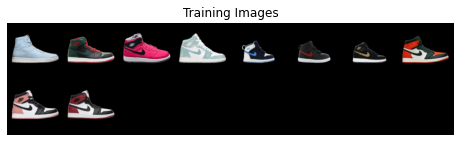

In [50]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))

In [51]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [53]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [54]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
             # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [55]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [56]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [57]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [58]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0/70][0/61]	Loss_D: 1.3042	Loss_G: 4.4891	D(x): 0.4183	D(G(z)): 0.3241 / 0.0141
[0/70][50/61]	Loss_D: 0.4251	Loss_G: 20.1115	D(x): 0.9937	D(G(z)): 0.3155 / 0.0000


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/70][0/61]	Loss_D: 0.2191	Loss_G: 7.1016	D(x): 0.9063	D(G(z)): 0.0038 / 0.0012
[1/70][50/61]	Loss_D: 0.0239	Loss_G: 8.4673	D(x): 0.9986	D(G(z)): 0.0220 / 0.0006


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[2/70][0/61]	Loss_D: 0.0136	Loss_G: 9.0524	D(x): 0.9907	D(G(z)): 0.0041 / 0.0007
[2/70][50/61]	Loss_D: 0.3698	Loss_G: 6.4931	D(x): 0.9871	D(G(z)): 0.2706 / 0.0028


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[3/70][0/61]	Loss_D: 2.6334	Loss_G: 0.5172	D(x): 0.3025	D(G(z)): 0.0770 / 0.6545
[3/70][50/61]	Loss_D: 0.7644	Loss_G: 3.4269	D(x): 0.7685	D(G(z)): 0.3695 / 0.0408


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[4/70][0/61]	Loss_D: 0.9417	Loss_G: 2.1680	D(x): 0.4432	D(G(z)): 0.0558 / 0.1203
[4/70][50/61]	Loss_D: 0.7317	Loss_G: 2.1629	D(x): 0.6796	D(G(z)): 0.2460 / 0.1198


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[5/70][0/61]	Loss_D: 0.7163	Loss_G: 3.5974	D(x): 0.6152	D(G(z)): 0.0652 / 0.0411
[5/70][50/61]	Loss_D: 0.4199	Loss_G: 3.6288	D(x): 0.8279	D(G(z)): 0.1868 / 0.0368


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[6/70][0/61]	Loss_D: 0.4375	Loss_G: 4.3968	D(x): 0.7313	D(G(z)): 0.0844 / 0.0171
[6/70][50/61]	Loss_D: 0.8069	Loss_G: 3.3039	D(x): 0.6202	D(G(z)): 0.1622 / 0.0628


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[7/70][0/61]	Loss_D: 1.1436	Loss_G: 1.8915	D(x): 0.3779	D(G(z)): 0.0313 / 0.2715
[7/70][50/61]	Loss_D: 1.4951	Loss_G: 2.1621	D(x): 0.6648	D(G(z)): 0.5610 / 0.1758


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[8/70][0/61]	Loss_D: 0.7767	Loss_G: 2.8198	D(x): 0.5817	D(G(z)): 0.0833 / 0.0851
[8/70][50/61]	Loss_D: 0.9557	Loss_G: 1.4114	D(x): 0.5009	D(G(z)): 0.1154 / 0.2665


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[9/70][0/61]	Loss_D: 1.0394	Loss_G: 3.9492	D(x): 0.9281	D(G(z)): 0.5429 / 0.0266
[9/70][50/61]	Loss_D: 1.1708	Loss_G: 2.4411	D(x): 0.5942	D(G(z)): 0.4001 / 0.1262


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[10/70][0/61]	Loss_D: 0.9597	Loss_G: 4.6163	D(x): 0.9092	D(G(z)): 0.5202 / 0.0136
[10/70][50/61]	Loss_D: 1.1092	Loss_G: 3.6239	D(x): 0.9135	D(G(z)): 0.6179 / 0.0292


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[11/70][0/61]	Loss_D: 0.7641	Loss_G: 3.1840	D(x): 0.8879	D(G(z)): 0.4357 / 0.0501
[11/70][50/61]	Loss_D: 1.3435	Loss_G: 6.2654	D(x): 0.9728	D(G(z)): 0.7037 / 0.0047


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/70][0/61]	Loss_D: 1.4211	Loss_G: 2.3848	D(x): 0.5878	D(G(z)): 0.4133 / 0.1100
[12/70][50/61]	Loss_D: 0.5821	Loss_G: 3.0303	D(x): 0.9298	D(G(z)): 0.3352 / 0.0591


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[13/70][0/61]	Loss_D: 0.9728	Loss_G: 3.4760	D(x): 0.7884	D(G(z)): 0.4612 / 0.0404
[13/70][50/61]	Loss_D: 1.0291	Loss_G: 2.5527	D(x): 0.8510	D(G(z)): 0.5144 / 0.0940


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[14/70][0/61]	Loss_D: 0.9630	Loss_G: 3.5952	D(x): 0.8677	D(G(z)): 0.5219 / 0.0319
[14/70][50/61]	Loss_D: 0.2030	Loss_G: 4.6073	D(x): 0.9471	D(G(z)): 0.1278 / 0.0131


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[15/70][0/61]	Loss_D: 0.6700	Loss_G: 2.5206	D(x): 0.7827	D(G(z)): 0.2839 / 0.0951
[15/70][50/61]	Loss_D: 0.7661	Loss_G: 1.9835	D(x): 0.6065	D(G(z)): 0.1499 / 0.1900


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[16/70][0/61]	Loss_D: 0.6220	Loss_G: 2.9035	D(x): 0.6221	D(G(z)): 0.0905 / 0.0726
[16/70][50/61]	Loss_D: 0.6389	Loss_G: 3.1100	D(x): 0.8057	D(G(z)): 0.3105 / 0.0481


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[17/70][0/61]	Loss_D: 0.9916	Loss_G: 2.9456	D(x): 0.6448	D(G(z)): 0.3629 / 0.0737
[17/70][50/61]	Loss_D: 1.5674	Loss_G: 2.1670	D(x): 0.4959	D(G(z)): 0.4187 / 0.1397


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[18/70][0/61]	Loss_D: 0.4504	Loss_G: 4.5795	D(x): 0.7818	D(G(z)): 0.1451 / 0.0143
[18/70][50/61]	Loss_D: 1.4414	Loss_G: 2.7861	D(x): 0.4043	D(G(z)): 0.0300 / 0.0700


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[19/70][0/61]	Loss_D: 0.6816	Loss_G: 2.3107	D(x): 0.6073	D(G(z)): 0.1252 / 0.1108
[19/70][50/61]	Loss_D: 0.6204	Loss_G: 2.9688	D(x): 0.8010	D(G(z)): 0.2828 / 0.0627


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[20/70][0/61]	Loss_D: 0.7969	Loss_G: 2.3594	D(x): 0.7828	D(G(z)): 0.3772 / 0.1132
[20/70][50/61]	Loss_D: 0.5546	Loss_G: 3.0235	D(x): 0.7374	D(G(z)): 0.1980 / 0.0584


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[21/70][0/61]	Loss_D: 0.8357	Loss_G: 2.5800	D(x): 0.5068	D(G(z)): 0.0495 / 0.1118
[21/70][50/61]	Loss_D: 2.5806	Loss_G: 2.7321	D(x): 0.9141	D(G(z)): 0.8805 / 0.1295


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[22/70][0/61]	Loss_D: 1.6203	Loss_G: 1.5323	D(x): 0.3032	D(G(z)): 0.0410 / 0.2437
[22/70][50/61]	Loss_D: 1.5448	Loss_G: 0.9387	D(x): 0.4517	D(G(z)): 0.3702 / 0.4124


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[23/70][0/61]	Loss_D: 0.9134	Loss_G: 1.8751	D(x): 0.5903	D(G(z)): 0.1595 / 0.1876
[23/70][50/61]	Loss_D: 1.6900	Loss_G: 1.2158	D(x): 0.2548	D(G(z)): 0.0463 / 0.3432


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[24/70][0/61]	Loss_D: 0.7047	Loss_G: 3.5766	D(x): 0.6904	D(G(z)): 0.2590 / 0.0386
[24/70][50/61]	Loss_D: 1.5352	Loss_G: 1.2526	D(x): 0.3305	D(G(z)): 0.1527 / 0.3257


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[25/70][0/61]	Loss_D: 1.3386	Loss_G: 2.7745	D(x): 0.6522	D(G(z)): 0.5158 / 0.0741
[25/70][50/61]	Loss_D: 0.5130	Loss_G: 3.0979	D(x): 0.8758	D(G(z)): 0.2984 / 0.0584


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[26/70][0/61]	Loss_D: 1.3432	Loss_G: 3.4338	D(x): 0.9028	D(G(z)): 0.6291 / 0.0470
[26/70][50/61]	Loss_D: 1.1055	Loss_G: 0.8751	D(x): 0.4089	D(G(z)): 0.1343 / 0.4452


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[27/70][0/61]	Loss_D: 1.1585	Loss_G: 2.2634	D(x): 0.8859	D(G(z)): 0.6165 / 0.1196
[27/70][50/61]	Loss_D: 1.1771	Loss_G: 2.8927	D(x): 0.7356	D(G(z)): 0.5361 / 0.0697


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[28/70][0/61]	Loss_D: 0.4314	Loss_G: 3.1664	D(x): 0.8220	D(G(z)): 0.1775 / 0.0557
[28/70][50/61]	Loss_D: 0.8182	Loss_G: 1.9851	D(x): 0.5146	D(G(z)): 0.0936 / 0.2025


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[29/70][0/61]	Loss_D: 1.4106	Loss_G: 1.8605	D(x): 0.3782	D(G(z)): 0.1943 / 0.1858
[29/70][50/61]	Loss_D: 0.9906	Loss_G: 2.9803	D(x): 0.6672	D(G(z)): 0.3176 / 0.0554


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[30/70][0/61]	Loss_D: 0.4864	Loss_G: 3.2685	D(x): 0.8752	D(G(z)): 0.2766 / 0.0486
[30/70][50/61]	Loss_D: 1.0131	Loss_G: 1.1826	D(x): 0.4934	D(G(z)): 0.1862 / 0.3157


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[31/70][0/61]	Loss_D: 1.8940	Loss_G: 2.4903	D(x): 0.2383	D(G(z)): 0.0795 / 0.1434
[31/70][50/61]	Loss_D: 1.9987	Loss_G: 3.2869	D(x): 0.8374	D(G(z)): 0.8071 / 0.0515


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[32/70][0/61]	Loss_D: 1.0331	Loss_G: 2.8192	D(x): 0.8464	D(G(z)): 0.5457 / 0.0681
[32/70][50/61]	Loss_D: 0.9426	Loss_G: 3.5892	D(x): 0.7524	D(G(z)): 0.4410 / 0.0323


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[33/70][0/61]	Loss_D: 0.4312	Loss_G: 3.9705	D(x): 0.8696	D(G(z)): 0.2205 / 0.0237
[33/70][50/61]	Loss_D: 0.4977	Loss_G: 4.3141	D(x): 0.9481	D(G(z)): 0.3400 / 0.0158


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[34/70][0/61]	Loss_D: 0.9248	Loss_G: 3.0743	D(x): 0.7821	D(G(z)): 0.4297 / 0.0543
[34/70][50/61]	Loss_D: 0.7586	Loss_G: 3.2432	D(x): 0.5910	D(G(z)): 0.0826 / 0.0538


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[35/70][0/61]	Loss_D: 0.8651	Loss_G: 3.2330	D(x): 0.5026	D(G(z)): 0.0545 / 0.0525
[35/70][50/61]	Loss_D: 0.9575	Loss_G: 2.9480	D(x): 0.7386	D(G(z)): 0.4526 / 0.0604


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[36/70][0/61]	Loss_D: 0.9634	Loss_G: 3.3987	D(x): 0.9041	D(G(z)): 0.5601 / 0.0416
[36/70][50/61]	Loss_D: 0.6874	Loss_G: 3.4701	D(x): 0.9355	D(G(z)): 0.3897 / 0.0475


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[37/70][0/61]	Loss_D: 0.5349	Loss_G: 2.4654	D(x): 0.7816	D(G(z)): 0.1960 / 0.1142
[37/70][50/61]	Loss_D: 0.7730	Loss_G: 3.9686	D(x): 0.9363	D(G(z)): 0.4745 / 0.0280


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[38/70][0/61]	Loss_D: 1.1851	Loss_G: 3.6452	D(x): 0.9733	D(G(z)): 0.6255 / 0.0348
[38/70][50/61]	Loss_D: 0.7838	Loss_G: 2.1166	D(x): 0.5829	D(G(z)): 0.1619 / 0.1381


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[39/70][0/61]	Loss_D: 1.0734	Loss_G: 2.0702	D(x): 0.6651	D(G(z)): 0.3548 / 0.2067
[39/70][50/61]	Loss_D: 2.0243	Loss_G: 3.1135	D(x): 0.4088	D(G(z)): 0.4493 / 0.0670


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[40/70][0/61]	Loss_D: 1.1685	Loss_G: 1.9346	D(x): 0.3985	D(G(z)): 0.0354 / 0.1525
[40/70][50/61]	Loss_D: 1.3790	Loss_G: 3.2487	D(x): 0.7153	D(G(z)): 0.5879 / 0.0438


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[41/70][0/61]	Loss_D: 0.6774	Loss_G: 3.0174	D(x): 0.8574	D(G(z)): 0.3205 / 0.0683
[41/70][50/61]	Loss_D: 1.0061	Loss_G: 4.1323	D(x): 0.9152	D(G(z)): 0.5687 / 0.0179


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[42/70][0/61]	Loss_D: 0.7388	Loss_G: 4.0440	D(x): 0.7750	D(G(z)): 0.3214 / 0.0245
[42/70][50/61]	Loss_D: 0.8413	Loss_G: 3.1096	D(x): 0.9312	D(G(z)): 0.4871 / 0.0530


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[43/70][0/61]	Loss_D: 1.0583	Loss_G: 1.4595	D(x): 0.4724	D(G(z)): 0.1785 / 0.2790
[43/70][50/61]	Loss_D: 0.3152	Loss_G: 2.6689	D(x): 0.8789	D(G(z)): 0.1448 / 0.0802


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[44/70][0/61]	Loss_D: 0.9922	Loss_G: 3.0474	D(x): 0.5468	D(G(z)): 0.2120 / 0.0777
[44/70][50/61]	Loss_D: 0.4634	Loss_G: 2.4427	D(x): 0.8241	D(G(z)): 0.2077 / 0.1001


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[45/70][0/61]	Loss_D: 0.6128	Loss_G: 4.2772	D(x): 0.9858	D(G(z)): 0.4022 / 0.0173
[45/70][50/61]	Loss_D: 1.0086	Loss_G: 2.3764	D(x): 0.4324	D(G(z)): 0.0536 / 0.1135


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[46/70][0/61]	Loss_D: 0.3722	Loss_G: 3.0265	D(x): 0.9486	D(G(z)): 0.2503 / 0.0530
[46/70][50/61]	Loss_D: 0.6229	Loss_G: 3.6985	D(x): 0.7532	D(G(z)): 0.2494 / 0.0269


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[47/70][0/61]	Loss_D: 0.3521	Loss_G: 3.4571	D(x): 0.9490	D(G(z)): 0.2464 / 0.0371
[47/70][50/61]	Loss_D: 1.0853	Loss_G: 4.4908	D(x): 0.8934	D(G(z)): 0.5049 / 0.0162


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[48/70][0/61]	Loss_D: 0.5612	Loss_G: 3.9120	D(x): 0.8167	D(G(z)): 0.2616 / 0.0273
[48/70][50/61]	Loss_D: 1.1482	Loss_G: 1.3500	D(x): 0.4182	D(G(z)): 0.1319 / 0.2937


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[49/70][0/61]	Loss_D: 0.4411	Loss_G: 3.0873	D(x): 0.7461	D(G(z)): 0.1229 / 0.0499
[49/70][50/61]	Loss_D: 0.9723	Loss_G: 3.1863	D(x): 0.6611	D(G(z)): 0.3503 / 0.0497


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[50/70][0/61]	Loss_D: 0.8996	Loss_G: 1.9370	D(x): 0.5647	D(G(z)): 0.1536 / 0.1748
[50/70][50/61]	Loss_D: 0.2298	Loss_G: 3.5358	D(x): 0.8367	D(G(z)): 0.0367 / 0.0421


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[51/70][0/61]	Loss_D: 0.9795	Loss_G: 4.3277	D(x): 0.8355	D(G(z)): 0.4811 / 0.0166
[51/70][50/61]	Loss_D: 1.3149	Loss_G: 5.4583	D(x): 0.9270	D(G(z)): 0.6529 / 0.0085


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[52/70][0/61]	Loss_D: 0.4084	Loss_G: 2.8729	D(x): 0.9554	D(G(z)): 0.2941 / 0.0630
[52/70][50/61]	Loss_D: 0.4119	Loss_G: 2.3519	D(x): 0.7471	D(G(z)): 0.0763 / 0.1206


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[53/70][0/61]	Loss_D: 0.3959	Loss_G: 3.7238	D(x): 0.8855	D(G(z)): 0.1857 / 0.0327
[53/70][50/61]	Loss_D: 0.7017	Loss_G: 4.6932	D(x): 0.9817	D(G(z)): 0.4682 / 0.0136


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[54/70][0/61]	Loss_D: 0.4119	Loss_G: 3.8543	D(x): 0.9961	D(G(z)): 0.2791 / 0.0258
[54/70][50/61]	Loss_D: 0.4800	Loss_G: 4.3795	D(x): 0.9183	D(G(z)): 0.3040 / 0.0161


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[55/70][0/61]	Loss_D: 1.1928	Loss_G: 3.1433	D(x): 0.4422	D(G(z)): 0.0874 / 0.0779
[55/70][50/61]	Loss_D: 1.3846	Loss_G: 1.2881	D(x): 0.4075	D(G(z)): 0.1677 / 0.3258


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[56/70][0/61]	Loss_D: 0.6056	Loss_G: 4.2301	D(x): 0.8423	D(G(z)): 0.2960 / 0.0244
[56/70][50/61]	Loss_D: 0.4394	Loss_G: 3.1803	D(x): 0.7153	D(G(z)): 0.0634 / 0.0524


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[57/70][0/61]	Loss_D: 1.0404	Loss_G: 2.3021	D(x): 0.5336	D(G(z)): 0.2222 / 0.1430
[57/70][50/61]	Loss_D: 0.6461	Loss_G: 3.5604	D(x): 0.7219	D(G(z)): 0.1905 / 0.0355


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[58/70][0/61]	Loss_D: 0.8104	Loss_G: 7.1162	D(x): 0.9830	D(G(z)): 0.4740 / 0.0015
[58/70][50/61]	Loss_D: 0.2553	Loss_G: 3.7334	D(x): 0.8556	D(G(z)): 0.0454 / 0.0317


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[59/70][0/61]	Loss_D: 0.3434	Loss_G: 3.6678	D(x): 0.8825	D(G(z)): 0.1823 / 0.0309
[59/70][50/61]	Loss_D: 0.5259	Loss_G: 3.1667	D(x): 0.9039	D(G(z)): 0.3122 / 0.0559


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[60/70][0/61]	Loss_D: 0.1500	Loss_G: 3.8755	D(x): 0.9592	D(G(z)): 0.0982 / 0.0304
[60/70][50/61]	Loss_D: 0.5023	Loss_G: 2.4696	D(x): 0.7040	D(G(z)): 0.1148 / 0.1331


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[61/70][0/61]	Loss_D: 0.3159	Loss_G: 5.1028	D(x): 0.9534	D(G(z)): 0.2115 / 0.0102
[61/70][50/61]	Loss_D: 0.6119	Loss_G: 3.2518	D(x): 0.7344	D(G(z)): 0.1865 / 0.0501


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[62/70][0/61]	Loss_D: 0.6450	Loss_G: 3.6007	D(x): 0.8490	D(G(z)): 0.3105 / 0.0358
[62/70][50/61]	Loss_D: 0.7454	Loss_G: 3.4393	D(x): 0.6193	D(G(z)): 0.0736 / 0.0471


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[63/70][0/61]	Loss_D: 0.4190	Loss_G: 3.1129	D(x): 0.8065	D(G(z)): 0.1570 / 0.0751
[63/70][50/61]	Loss_D: 0.3080	Loss_G: 3.4172	D(x): 0.8485	D(G(z)): 0.1106 / 0.0511


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[64/70][0/61]	Loss_D: 0.2093	Loss_G: 3.1024	D(x): 0.8733	D(G(z)): 0.0624 / 0.0673
[64/70][50/61]	Loss_D: 0.2435	Loss_G: 4.5539	D(x): 0.9117	D(G(z)): 0.1205 / 0.0195


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[65/70][0/61]	Loss_D: 0.3890	Loss_G: 4.2772	D(x): 0.8614	D(G(z)): 0.1959 / 0.0203
[65/70][50/61]	Loss_D: 0.3248	Loss_G: 4.6288	D(x): 0.9060	D(G(z)): 0.1747 / 0.0129


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[66/70][0/61]	Loss_D: 0.1862	Loss_G: 3.4303	D(x): 0.8989	D(G(z)): 0.0618 / 0.0431
[66/70][50/61]	Loss_D: 0.1784	Loss_G: 4.9539	D(x): 0.9289	D(G(z)): 0.0918 / 0.0114


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[67/70][0/61]	Loss_D: 0.8396	Loss_G: 6.7451	D(x): 0.9877	D(G(z)): 0.4834 / 0.0016
[67/70][50/61]	Loss_D: 0.7519	Loss_G: 1.7861	D(x): 0.6234	D(G(z)): 0.0880 / 0.2120


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[68/70][0/61]	Loss_D: 1.2188	Loss_G: 6.3958	D(x): 0.9237	D(G(z)): 0.5902 / 0.0031
[68/70][50/61]	Loss_D: 0.7732	Loss_G: 2.9848	D(x): 0.5406	D(G(z)): 0.0489 / 0.0885


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[69/70][0/61]	Loss_D: 0.3456	Loss_G: 4.9548	D(x): 0.9836	D(G(z)): 0.2428 / 0.0097
[69/70][50/61]	Loss_D: 0.4077	Loss_G: 5.9322	D(x): 0.9796	D(G(z)): 0.2729 / 0.0032


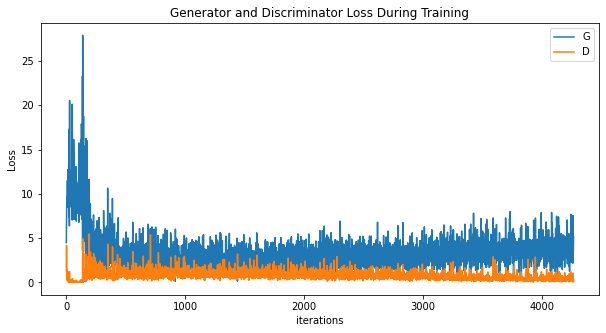

In [59]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

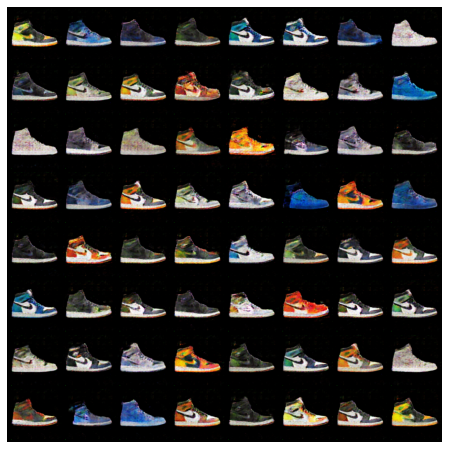

In [60]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


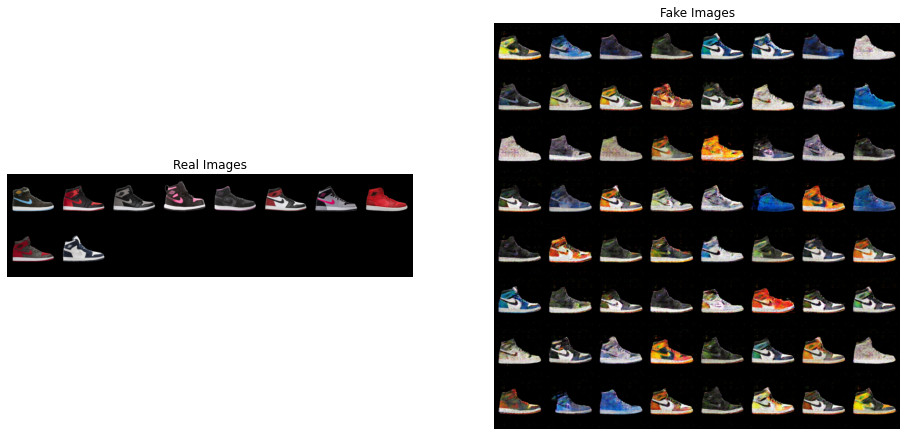

In [61]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()